In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 환경에 따라 PROJECT_ROOT 설정
if IN_COLAB:
    PROJECT_ROOT = '/content/drive/Othercomputers/내 Mac/Road_Lane_segmentation'
else:
    PROJECT_ROOT = Path.cwd().parents[0]

# sys.path 추가 (import용)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 작업 디렉토리 변경 (파일 접근용)
os.chdir(PROJECT_ROOT)

print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Current working directory: {os.getcwd()}")

Environment: Local
PROJECT_ROOT: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation
Current working directory: /Users/mungughyeon/내 드라이브/likelion/Road_Lane_segmentation


In [3]:
from src.inference import Inferencer
from src.inference.visualize import mask_to_rgb
from src.utils.log import setup_logger

CHECKPOINT_PATH = "checkpoints/UnetPlusPlus_efficientnet-b4_Merge_Data/best.pt"
CONFIG_PATH = "configs/config.yaml"
IMAGE_PATH = "dataset/inference_img"
SAVE_PATH = "inference/UnetPlusPlus_efficientnet_b4-Merge_Data"

In [4]:
import cv2
from tqdm import tqdm

os.makedirs(SAVE_PATH, exist_ok=True)
logger = setup_logger(name="InferenceScript")
inferencer = Inferencer(checkpoint=CHECKPOINT_PATH, config_path=CONFIG_PATH)
logger.info("Inferencer loaded successfully.")

image_files = []
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']

for filename in os.listdir(IMAGE_PATH):
    if any(filename.lower().endswith(ext) for ext in valid_extensions):
        image_files.append(os.path.join(IMAGE_PATH, filename))

if not image_files:
    logger.warning(
        f"No image files found in {IMAGE_PATH}. Please check the directory and file extensions."
    )
else:
    logger.info(f"Found {len(image_files)} images in {IMAGE_PATH}. Starting inference...")

    # 각 이미지에 대해 추론 수행 및 저장 (tqdm 적용)
    for i, image_path in tqdm(
        enumerate(image_files),
        total=len(image_files),
        desc="Processing Images"
    ):
        logger.info(f"Processing image {i + 1}/{len(image_files)}: {image_path}")

        try:
            # 이미지 로드
            image = cv2.imdecode(
                np.fromfile(image_path, dtype=np.uint8),
                cv2.IMREAD_COLOR
            )

            if image is None:
                logger.warning(f"Could not read image {image_path}. Skipping.")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR → RGB
            predicted_mask = inferencer.predict(image) # 추론

            # 마스크 RGB 변환
            mask_rgb = mask_to_rgb(
                predicted_mask,
                num_classes=inferencer.num_classes
            )

            # 저장 경로
            original_filename_stem = Path(image_path).stem
            save_file_name = f"{original_filename_stem}_predicted_mask.png"
            save_full_path = os.path.join(SAVE_PATH, save_file_name)

            # 저장 (RGB → BGR)
            cv2.imwrite(
                save_full_path,
                cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
            )

            logger.info(f"Saved predicted mask to: {save_full_path}")

        except Exception:
            logger.error(f"Error processing {image_path}", exc_info=True)

    logger.info("Inference for all images completed.")

Device: mps
Loaded model weights from checkpoint: checkpoints/UnetPlusPlus_efficientnet-b4_Merge_Data/best.pt


Processing Images: 100%|██████████| 246/246 [01:09<00:00,  3.53it/s]


In [5]:
import random

def inferred_plot(mask_dir, num_samples=6):

    # 폴더 내 모든 마스크 파일 리스트업
    all_files = [f for f in os.listdir(mask_dir) if f.endswith('_predicted_mask.png')]
    
    if not all_files:
        print(f"해당 경로에 '_predicted_mask.png' 파일이 없습니다: {mask_dir}")
        return

    # 설정한 개수만큼 랜덤 샘플링
    num_samples = min(num_samples, len(all_files))
    selected_files = random.sample(all_files, num_samples)

    # 출력 설정: 한 줄에 3개씩 배치
    cols = 3
    rows = (num_samples + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten() # 2차원 배열을 1차원으로 펼쳐서 다루기 쉽게 함

    for i in range(len(axes)):
        if i < len(selected_files):
            file_name = selected_files[i]
            file_path = os.path.join(mask_dir, file_name)
            
            # 이미지 로드 (한글 경로 대응)
            img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(img)
            axes[i].set_title(f"Inferred: {file_name}", fontsize=10)
            axes[i].axis('off')
        else:
            # 남는 빈 칸은 숨김 처리
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

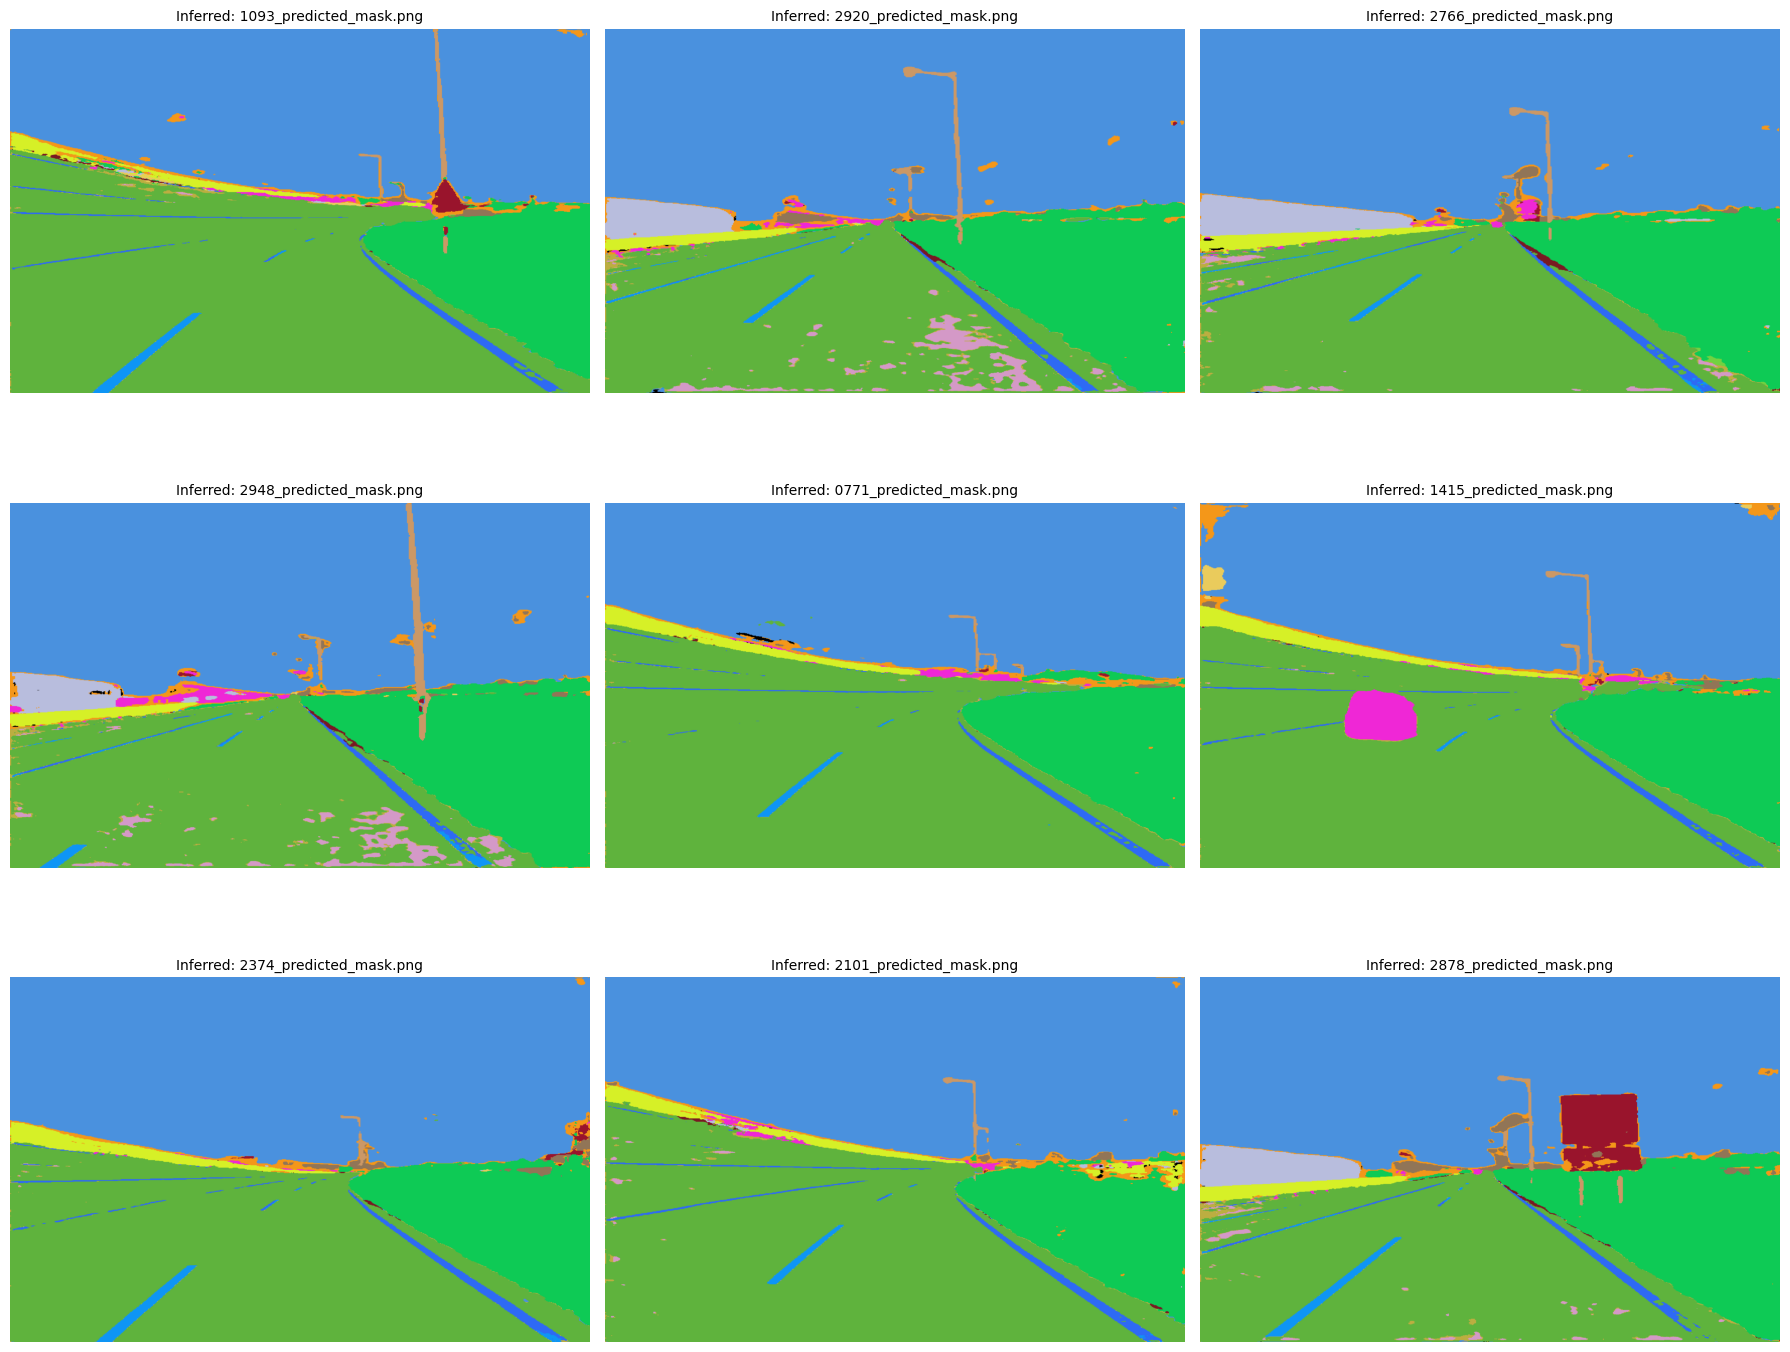

In [8]:
inferred_plot(SAVE_PATH, num_samples=9)